In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Импортируем нужные библиотеки

#### Считывание и обработка данных

In [3]:
df = pd.read_excel("200_выпусков_'О_мой_питч!'_OutOfScope_update.xlsx", sheet_name='Лист2')
df = df.rename(columns={'Инвестиции' : 'Инвестиции(руб)', 'Без' : 'Воздержалось'})
df['За'] = pd.to_numeric(df['За'], errors='coerce')
df['Против'] = pd.to_numeric(df['Против'], errors='coerce')
df['Воздержалось'] = pd.to_numeric(df['Воздержалось'], errors='coerce')
df = df.drop(columns='№')
df = df.drop(index=82) #Дропаем строку в бизнесом, о котором нет данных
df = df.drop_duplicates(subset='Название')
pd.set_option('display.max_colwidth', None)  # 150 означает ограничение на кол-во символов в колонке "Описание"


#### Основные метрики по инвестициям и голосам в опросах

In [4]:
# Форматируем вывод чисел (два знака для float, целые для int)
pd.options.display.float_format = '{:,.2f}'.format

description = df[['Инвестиции(руб)', 'За', 'Против', 'Воздержалось', 'Всего']].describe()
description['Инвестиции(руб)'] = (description['Инвестиции(руб)'] / 1_000_000).round(2)
description[['За', 'Против', 'Воздержалось', 'Всего']] = description[['За', 'Против', 'Воздержалось', 'Всего']].astype(int)
description.rename(columns={'Инвестиции(руб)': 'Инвестиции (млн, руб)'}, inplace=True)
description_selected = description.loc[['mean', '25%', '50%', '75%', 'min', 'max']]
description_renamed = description_selected.rename(index={
    'mean': 'Среднее',
    '25%': '25-й перцентиль',
    '50%': 'Медиана (50-й перцентиль)',
    '75%': '75-й перцентиль',
    'min': 'Минимум',
    'max': 'Максимум'
})

description_renamed

,"Инвестиции (млн, руб)",За,Против,Воздержалось,Всего
Среднее,48.36,149,204,134,445
25-й перцентиль,7.09,95,132,101,358
Медиана (50-й перцентиль),22.50,128,176,131,435
75-й перцентиль,45.00,184,250,155,527
Минимум,0.00,35,43,61,182
Максимум,900.00,519,535,385,735


#### Скользящее среднее количества голосов от даты

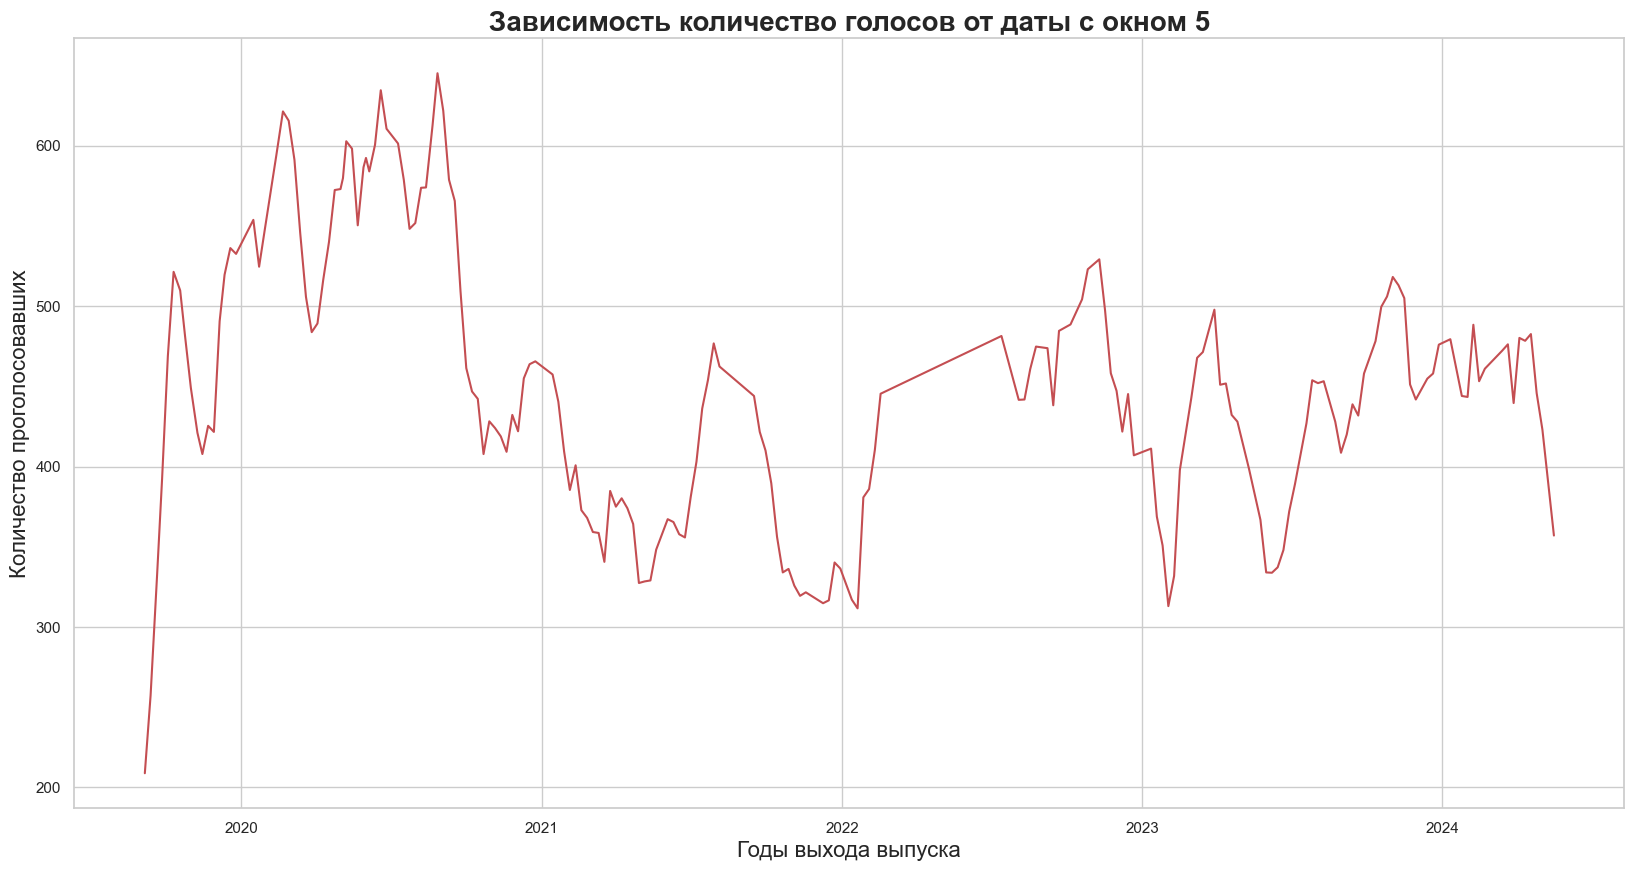

In [5]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(20, 10))

df['Всего_rolling'] = df['Всего'].rolling(window=5).mean()
sns.lineplot(x='Дата', y='Всего_rolling', data=df, color='r')


plt.xlabel('Годы выхода выпуска', fontsize=16)
plt.ylabel('Количество проголосовавших', fontsize=16)
plt.title('Зависимость количество голосов от даты c окном 5', fontsize=20, fontweight='bold')
plt.show()






Из графика видно, что опросы стали проводиться примерно осенью 2019 года. Можно предположить, что выпуски начали выходить примерно в то же время.
Примерно за год количество голосов в опросах выросло примерно в 3 раза и к осени 2020 года достигло своего локального максимума.
С 2021 года и по наше время количество проголосовавших колеблется примерно от 300 до 500 

### Разбивка стартапов по группам

In [6]:
keywords = {
    'ТГ-боты' : ['телеграм', 'telegram'],
    'Взаимоотношения' : ['коммуникац', 'познакомиться', 'знакомств', 'отношени', 'свидани'],
    'AI_помощники' : ['виртуальн', 'помощник', 'ai', 'искусственны', 'интелект', 'ии', 'бот'],
    'Маркетинг_и_реклама' : ['реклам', 'маркетинг', 'анализ', 'акци', 'контент'],
    'B2B' : ['b2b', 'бизнес'],
    'Медицина' : ['диагностик ', 'профилактик', 'медицин', 'врач', 'докт', 'хирург ', 'операц', 'маломобильных', 'процедур','здоровь', 'вирус', 'психолог', 'таблет', 'больн'],
    'Образование': ['студент', 'университет', 'школ', 'образован', 'универ', 'экзамен', 'курс', 'общежит', 'образован', 'обучени'],
    'Музыка': ['музык', 'песн', 'звук', 'аккорд', 'мелод'],
    'Спорт': ['тренировк', 'фитнес', 'физкультур', 'атлетик', 'кардио', 'нагруз', 'сорев', 'экипиров', 'упражнен'],
    'Транспорт_и_доставка': ['машина', 'техобслуж', 'кузов', 'транспорт', 'курьер', 'доставк', 'груз', 'логистик', 'автомобил','маршрут', 'навигатор', 'двигател'],
    'Путешествия': ['поездк', 'туризм', 'путешеств', 'путевк', 'экскурси', 'курорт', 'проживание', 'travel'],
    'Кулинария': ['кухн', 'повар', 'еда', 'пищ', 'рецепт', 'ингредиент', 'блюд', 'еды', 'общепит', 'едой'],
    
    
}

def categorize(description):
    matched_categories = []
    words_in_description = description.lower().split()  # Разбиваем описание на слова
    
    for category, words in keywords.items():
        if any(any(word.startswith(keyword) for keyword in words) for word in words_in_description):
            matched_categories.append(category)
            
    return ', '.join(matched_categories) if matched_categories else 'Прочее'

# Пример датафрейма
df['Категория'] = df['Описание'].apply(categorize)

# Вывести результат
df['Категория'].unique()


array(['Маркетинг_и_реклама', 'Маркетинг_и_реклама, Медицина',
       'ТГ-боты, Взаимоотношения, B2B',
       'AI_помощники, Транспорт_и_доставка', 'B2B', 'Взаимоотношения',
       'AI_помощники, B2B, Медицина', 'ТГ-боты', 'ТГ-боты, AI_помощники',
       'Прочее', 'Медицина', 'AI_помощники, Медицина',
       'Взаимоотношения, AI_помощники', 'AI_помощники, B2B',
       'AI_помощники, Образование', 'Музыка', 'B2B, Образование',
       'Образование', 'AI_помощники, Спорт', 'AI_помощники',
       'AI_помощники, B2B, Транспорт_и_доставка, Путешествия',
       'Транспорт_и_доставка, Кулинария', 'Транспорт_и_доставка',
       'AI_помощники, Маркетинг_и_реклама',
       'ТГ-боты, Взаимоотношения, AI_помощники',
       'Маркетинг_и_реклама, Транспорт_и_доставка, Кулинария',
       'ТГ-боты, Маркетинг_и_реклама',
       'Маркетинг_и_реклама, Транспорт_и_доставка',
       'Маркетинг_и_реклама, Образование', 'Маркетинг_и_реклама, B2B',
       'Маркетинг_и_реклама, B2B, Транспорт_и_доставка', 'Спор



Для разбивки используются ключевые слова, которые наиболее подходят для выбраной категории. Слова выбирались по принципу запроса "топ-10 слов на тему "нужная тема", затем был проведен осмотр на наличие и удаление общих слов (слов с общими корнями, по типу "авто"), также переработан подход к парсингу: теперь слова в описании должны НАЧИНАТЬСЯ с ключевых слов, а не просто содержать корни в любом месте слова. После этого был проведен вторичный осмотр на "откровенно" ложные данные. Поскольку изначально не стоит задача идеально распределить все стартапы, а лишь раздеить их "условные" группы, основываясь на вторичную проверку, а также на получившиеся графики, можно сделать вывод о том, что IT - как и ожидалось, имеет наибольшую долю



#### Определение категорий



##### ТГ-боты
К категории относятся стартапы, в которых основным продуктом является телеграм-бот


##### Взаимоотношения
Категория стартапов, в которых сосреточены приложения для знакомств, семейные психологи
  

##### AI_помощники
Стартапы с помощниками на искусственном интеллекте, которые выполняют самые разные задачи, от консультации по тренировкам до помощи в разработке приложений
   

##### Маркетинг_и_реклама
Категория содержит стартапы, которые предоставляют различные услуги продвижения малым, средним, крумным бизнесам
 

   ##### B2B
   Стартапы, которые непосредственно помогают бизнесам развиваться (различные конструкторы, платформы и другое)
  

##### Медицина 
Различные девайсы для защиты здоровья, также имеются сервисы с AI, которые помогают врачам в разных областях проводить сложные операции
  

##### Образование 
Стартапы-онлайн-школы, различные сервисы для студентов

##### Музыка 
Сервис цифровой дистрибуции и маркетплейс по продаже песен

##### Спорт
Приложения, которые составляют план тренировок, фитнес-трекеры

##### Транспорт_и_доставка
В основном сервисы/приложения/боты по доставке продуктов или вещей, однако есть и различные сервисы для ремонта или обслуживания транспорта

##### Путешествия
Стартапы из этой категории помогают найти дом, которые будет наиболее подходящим, также есть сервисы для создания персонального плана путешествий

##### Кулинария
В основном сервисы бесконтактного заказа еды

#### Примеры случайных стартапов из каждой категории


In [16]:


# Функция для выбора случайного стартапа в каждой категории
def get_random_startup_by_category(df, columns_to_display):
    # Проверка на наличие всех столбцов в DataFrame
    missing_columns = [col for col in columns_to_display if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Следующие столбцы отсутствуют в DataFrame: {missing_columns}")
    
    random_startups = []
    grouped = df.groupby('Категория')  # Группируем по категории
    
    for category, group in grouped:
        random_startup = group.sample(1)  # Выбираем 1 случайный стартап из группы
        random_startups.append(random_startup)
    
    # Соединяем результаты в один DataFrame
    result_df = pd.concat(random_startups)
    
    # Отображаем только нужные столбцы
    return result_df[columns_to_display]

# Пример вызова
columns_to_display = ['Название', 'Описание', 'Категория']  
random_startups_df = get_random_startup_by_category(df, columns_to_display)

random_startups_df

,Название,Описание,Категория
185,Dr. Ekman,"Карманный бот-психолог, помогающий при эмоциональных проблемах. Сервис с помощью искусственного интеллекта может помочь разобрать ваше состояние, дать советы и подобрать психотерапевта.",AI_помощники
90,AI Eye,"AI Eye - B2B SaaS приложение для контроля действий водителей и предотвращения ДТП. С помощью недорогого смартфона и обычной wi-fi камеры мы распознаём отвлечённое вождение и усталость, предупреждаем водителя и передаём видеозапись события на сервер","AI_помощники, B2B"
9,RecPlace,"Платформа комплексного развития бизнеса, силами ИИ, обученного на опыте экспертов в вашей нише. С помощью ИИ RecPlace помогает настраивать эффективное управление, привлечение клиентов и увеличение операционной эффективности. Проект ориентирован на малый и микробизнес. По оценке компании, в этом сегменте более 6,1 млн микробизнесов. И у них нет маркетологов и доступа к эффективным инструментам для роста, что приводит к закрытию 95% новых предприятий в течение первых трех лет","AI_помощники, B2B, Медицина"
51,Pinsteps,"Пересаживаем рынок экскурсий и гидов на цифровые маршруты, в которые с AI интегрированы локальные бизнесы. Создаем экосистемы для городов, объединяющие всех участников. Умудрились сделать успешный пилот в разгар пандемии в Израиле.","AI_помощники, B2B, Транспорт_и_доставка, Путешествия"
173,Eskulabs,AI-платформа для хранения и анализа УЗИ-снимков и видео. На данном этапе смотрят в сторону диагностики по различным патологиям.,"AI_помощники, Маркетинг_и_реклама"
159,Signum.ai,"Сервис помогает отслеживать зарождение новых трендов и хайпов на самых ранних этапах. Наш инструмент в режиме реального времени анализирует более миллиона источников (форумы, блоги, аккаунты в соцсетях) и определяет, какие товары, стили, рынки и компании будут востребованы завтра. Мы пошли дальше и воплотили в жизнь Искусственный Интеллект для автоматизации маркетинга, продаж и исследований рынков. Анализировать конкурентов, мониторить сотни площадок, документов и изменений - это классическая задача для машинного обучения.","AI_помощники, Маркетинг_и_реклама, Образование"
95,Sober One,"Sober One — мобильное приложение с AI, предлагающее людям планы помощи для осознания и решения проблем, связанных с алкоголем и злоупотреблением психоактивными веществами (substance abuse problems). Такие проблемы есть у 1,5 млрд человек, но помощь получают менее 5%. Существующие решения предлагают лечение, но люди не хотят лечиться. Наше приложение предоставляет знания, научно обоснованные инструменты и поддержку, помогая решить проблему без посещения врача или программы лечения.","AI_помощники, Медицина"
197,Azura AI,"Azura AI разрабатывает сервис для поддержания и профилактики здоровья, который:\n— хранит и автоматически собирает медицинские данные пользователя, в том числе и с фитнес-трекеров,\n— предоставляет персональные рекомендации по улучшению здоровья,\n— предсказывает вероятности возникновения заболеваний.\n\nРабота сервиса основана на применении искусственного интеллекта. В команде Azure AI есть и специалисты по ИИ, и врачи.","AI_помощники, Медицина, Спорт"
29,Viduchi,"В 1,5 раза увеличиваем скорость обучения индустриальных рабочих с помощью видео-инструкций и ИИ. Как это происходит? Опытный сотрудник записывает на видео последовательность своих действий, подробно озвучивает и объясняет каждый шаг, видео загружается на платформу, а она создает короткие инструкции для учеников, управление с помощью голоса.","AI_помощники, Образование"
42,FitMind.ai,"AI-ассистент для онлайн тренеров по фитнесу и велнесу, который помогает им качественнее отвечать на вопросы клиентов и экономить время","AI_помощники, Спорт"


#### Наиболее популярные категории в порядке убывания

In [8]:
# Функция для подсчета всех категорий, содержащих подкатегорию
def count_subcategory_occurrences(df, subcategories):
    # Разделение категорий на отдельные строки
    categories = df['Категория'].str.split(', ', expand=True)
    categories = categories.melt(value_name='Категория').dropna()['Категория']
    
    # Подсчет всех категорий, содержащих каждую подкатегорию из списка
    results = {}
    for subcategory in subcategories:
        count = categories[categories.str.contains(subcategory, case=True)].count()
        results[subcategory] = count
    
    # Сортировка по убыванию значений
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_results

# Список подкатегорий, которые нужно проверить
subcategories_list = ['Прочее', 'ТГ-боты', 'B2B', 'Взаимоотношения', 'AI_помощники', 'Музыка', 'Медицина', 'Спорт', 'Транспорт_и_доставка', 'Путешествия', 'Кулинария', 'Образование', 'Маркетинг_и_реклама']

# Подсчет количества всех категорий для каждой подкатегории в списке
subcategory_counts = count_subcategory_occurrences(df, subcategories_list)
subcategory_counts


{'Прочее': np.int64(61),
 'Маркетинг_и_реклама': np.int64(38),
 'AI_помощники': np.int64(33),
 'B2B': np.int64(25),
 'Транспорт_и_доставка': np.int64(23),
 'Медицина': np.int64(20),
 'Образование': np.int64(14),
 'Взаимоотношения': np.int64(9),
 'Кулинария': np.int64(9),
 'ТГ-боты': np.int64(8),
 'Путешествия': np.int64(8),
 'Спорт': np.int64(5),
 'Музыка': np.int64(2)}

#### Визуализируем данные

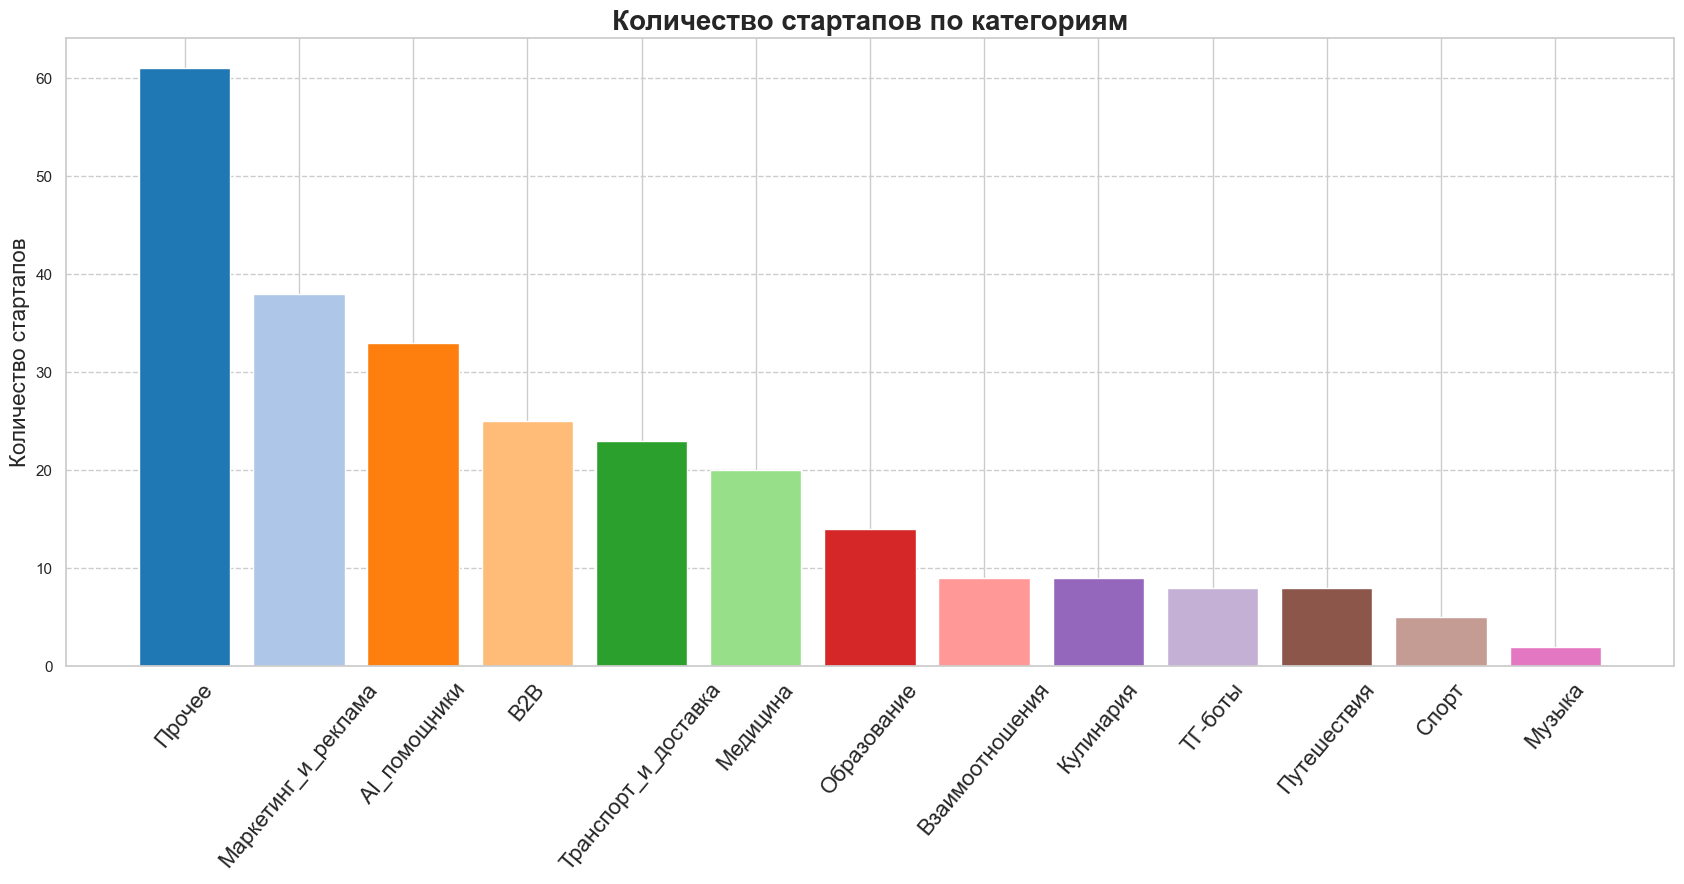

In [9]:
category_labels = list(subcategory_counts.keys())
category_counts = list(subcategory_counts.values())



colors = plt.get_cmap('tab20').colors

plt.figure(figsize=(17, 9))
plt.bar(
    category_labels, 
    category_counts, 
    color=colors[:len(category_labels)]  # Убедитесь, что достаточно цветов для всех категорий
)

plt.title('Количество стартапов по категориям', fontsize=20, fontweight='bold')
plt.ylabel('Количество стартапов', fontsize=16)
plt.xticks(rotation=50, fontsize=16)  # Поворот меток категорий, если они длинные
plt.grid(axis='y', linestyle='--')  # Сетка по вертикальной оси
plt.tight_layout()  # Подгонка для отображения меток
plt.show()



Видим, что распределение по заданным (предполагаемым) группам в основном сосредоточилось на маркетинге, рекламе и AI помощниках.

Это может быть связано с тем, что в настоящее время цифровые технологии применяются в любой области, что потверждается данными из массива уникальных подгрупп, почти в каждой из которых есть либо маркетинг с рекламой, либо AI

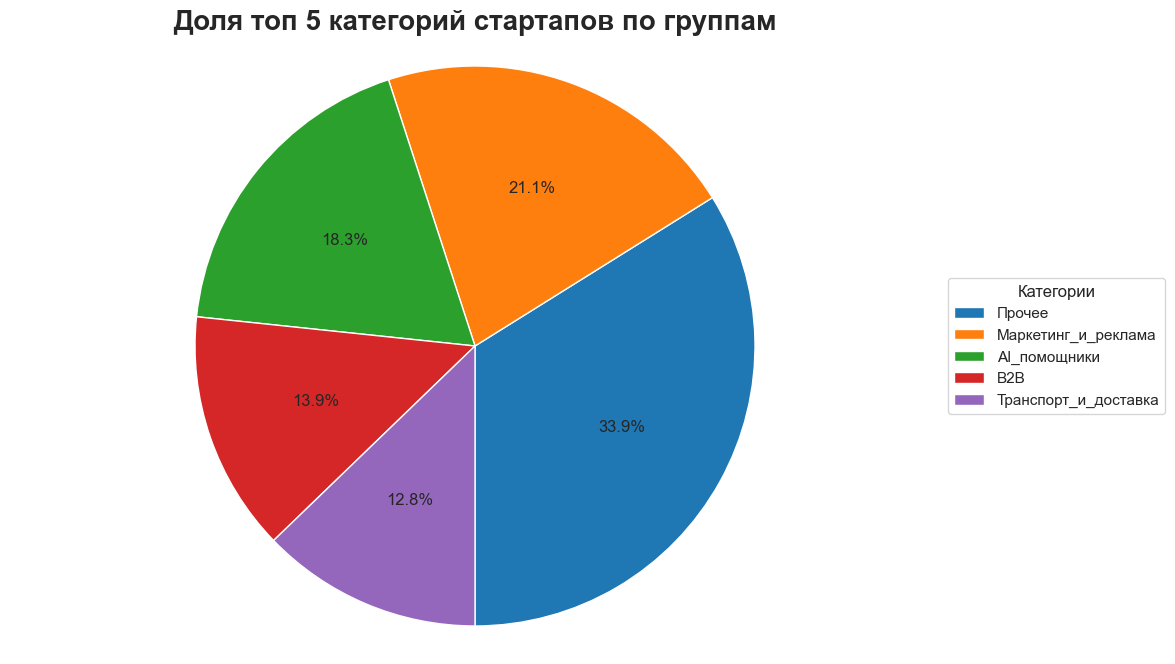

In [10]:

merge_to_other = ['Спорт', 'Музыка', 'Кулинария', 'Путешествия', 'ТГ-боты', 'Взаимоотношения', 'Образование', 'Медицина']

category_labels = list(subcategory_counts.keys())
category_counts = list(subcategory_counts.values())
other_count = 0

# Создаем новые списки для обновления
for label, count in zip(category_labels, category_counts):
    if label in merge_to_other:
        other_count += count  # Суммируем категории, которые пойдут в "Прочее"

# Удаляем объединенные категории из исходных списков
category_labels = [label for label in category_labels if label not in merge_to_other]
category_counts = [count for label, count in zip(category_labels, category_counts) if label not in merge_to_other]

# Определение цветов для каждого сегмента
colors = plt.get_cmap('tab10').colors

# Создание круговой диаграммы с объединением в "Прочее"
plt.figure(figsize=(12, 8))
plt.pie(
    category_counts,
    autopct='%1.1f%%', 
    colors=colors[:len(category_labels)],  # Убедитесь, что достаточно цветов для всех категорий
    startangle=-90
)

# Настройка легенды
plt.legend(
    category_labels,
    title="Категории",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title('Доля топ 5 категорий стартапов по группам', fontsize=20, fontweight='bold')
plt.axis('equal')  # Оформление диаграммы в круг
plt.show()



Заметим, что AI помощники ненамного отстают от макретинга и рекламы. Это связано с быстрым развитием искуственного интеллекта, поэтому сейчас все больше команд так или иначе используют AI в своих стартапах. Можно предположить, что скоро доля стартапов с AI помощниками станет больше, чем у стартапов по маркетингу.

Логистические стартапы в свою очередь не отстают от стартапов B2B. Это можно объяснить тем, что в современном мире появилось очень много новых логистических услуг. Доставка продуктов из магазина, еды из ресторана, грузоперевозки от небольших шкафов до жилых домов. Все это является причиной достаточно большой доли логистических стартапов

Также стоит отметить, что треть всех проектов либо не попала ни в одну из категорий, либо же процент от общего числа составлял меньше 10 %
Это может быть связано с тем, что разбивка по категориям имеют определенную погрешность
